In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Define the path to the zip file
zip_file_path = '/content/drive/MyDrive/archive.zip'

# Define the directory to extract the contents
extract_dir = '/content/drive/MyDrive/'

# Unzip the folder
os.system(f'unzip {zip_file_path} -d {extract_dir}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0

In [ ]:
!rm -r /content/drive/MyDrive/images/images


In [ ]:

# Define the main path to the dataset
dataset_path = '/content/drive/MyDrive/images'

# Function to count the number of images in each set and list subfolder classes
def count_images_and_classes(dataset_path):
    sets = ['train', 'test']
    set_counts = {}

    for set_name in sets:
        set_path = os.path.join(dataset_path, set_name)
        class_counts = {}

        for class_name in os.listdir(set_path):
            class_path = os.path.join(set_path, class_name)
            if os.path.isdir(class_path):
                # Count the number of images in each class
                count = len(os.listdir(class_path))
                class_counts[class_name] = count

        set_counts[set_name] = class_counts

    return set_counts

# Count images and list classes in the dataset
set_counts = count_images_and_classes(dataset_path)
print("Number of images in each set and class:")
for set_name, class_counts in set_counts.items():
    print(f"Set: {set_name}")
    for class_name, count in class_counts.items():
        print(f"\t{class_name}: {count}")

Number of images in each set and class:
Set: train
	angry: 3993
	disgust: 436
	fear: 4103
	happy: 7164
	neutral: 4982
	sad: 4938
	surprise: 3205
Set: test
	angry: 960
	disgust: 111
	fear: 1018
	happy: 1825
	neutral: 1216
	sad: 1139
	surprise: 797



Class: angry


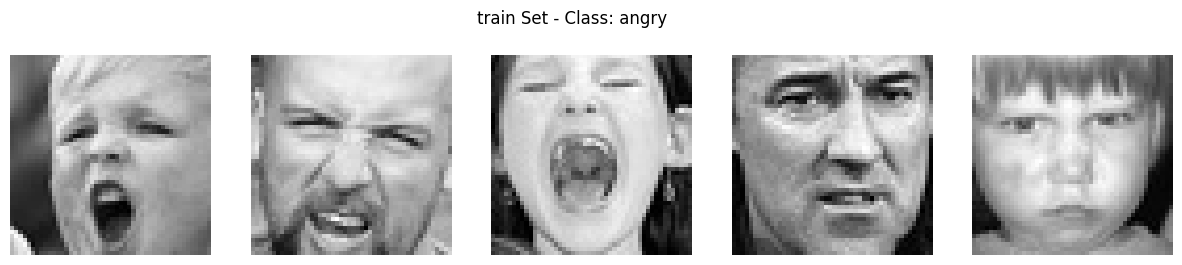


Class: disgust


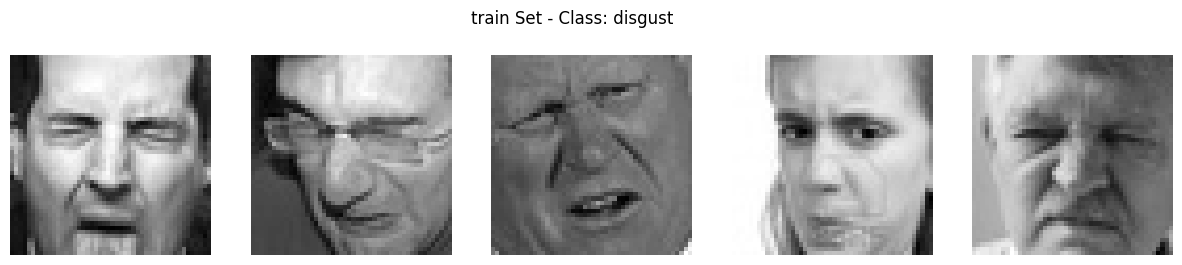


Class: fear


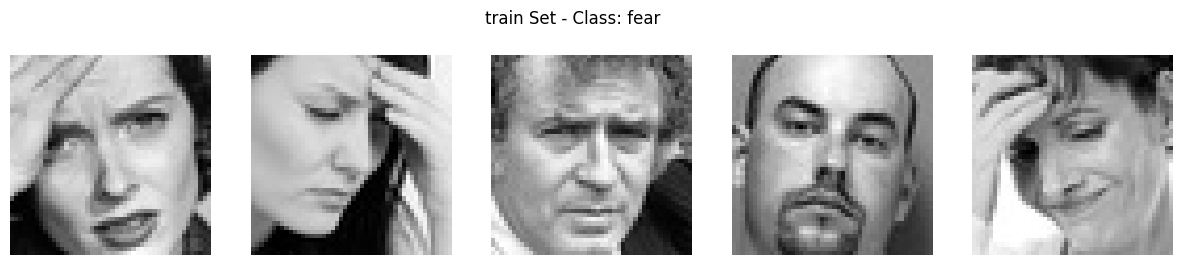


Class: happy


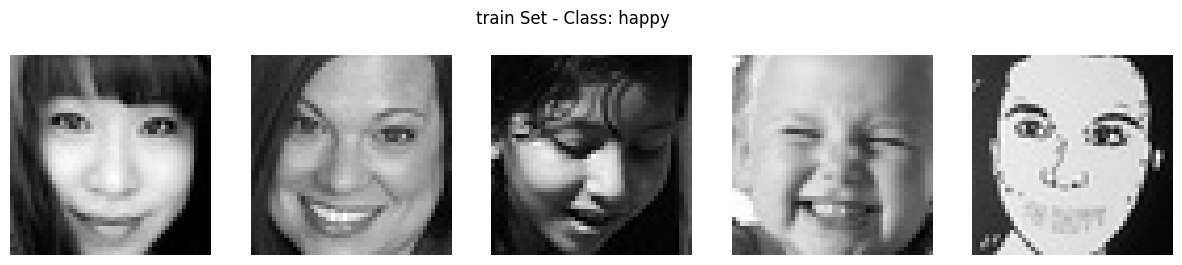


Class: neutral


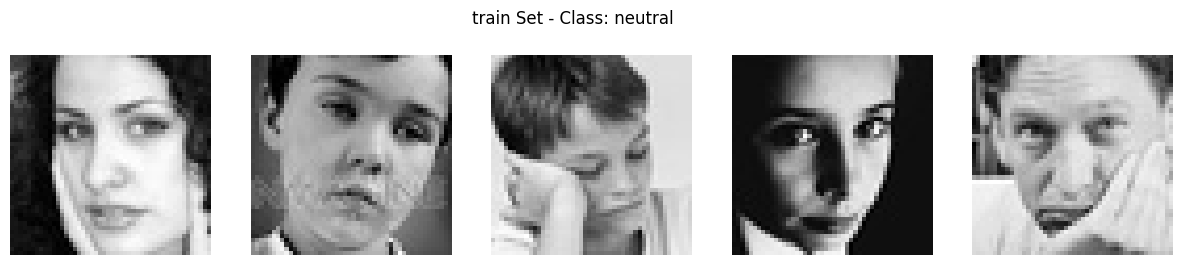


Class: sad


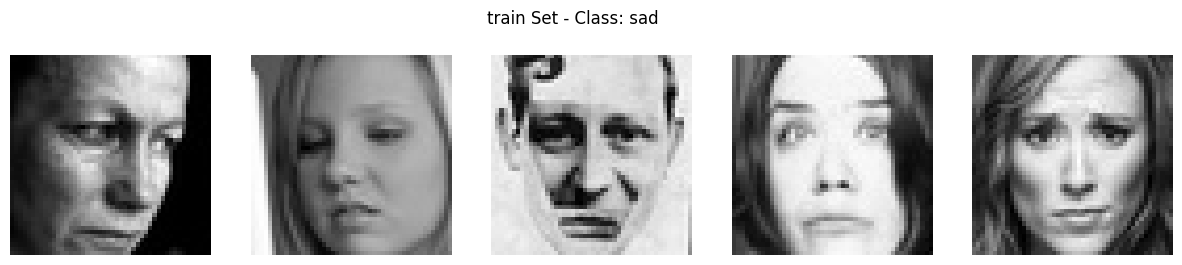


Class: surprise


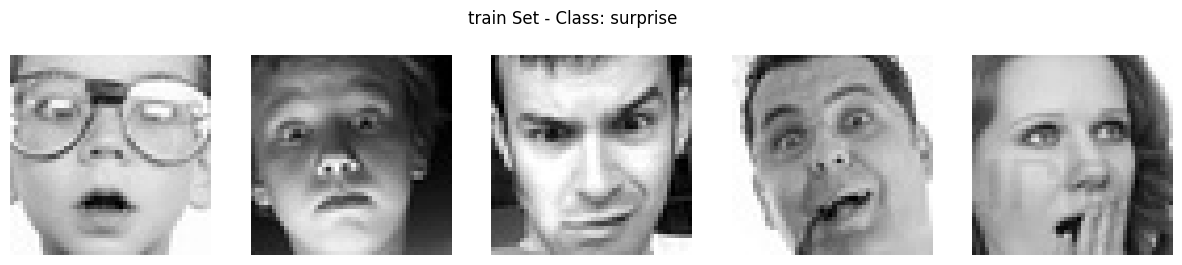


Class: angry


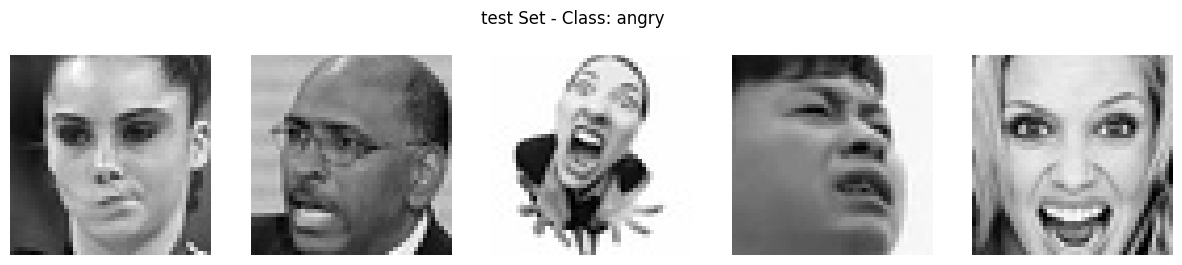


Class: disgust


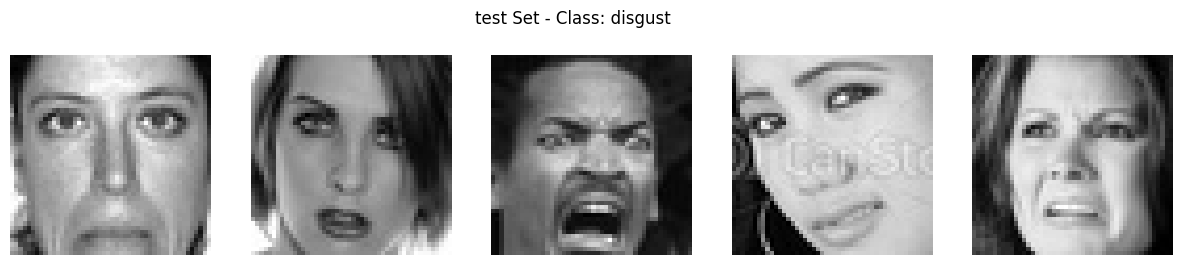


Class: fear


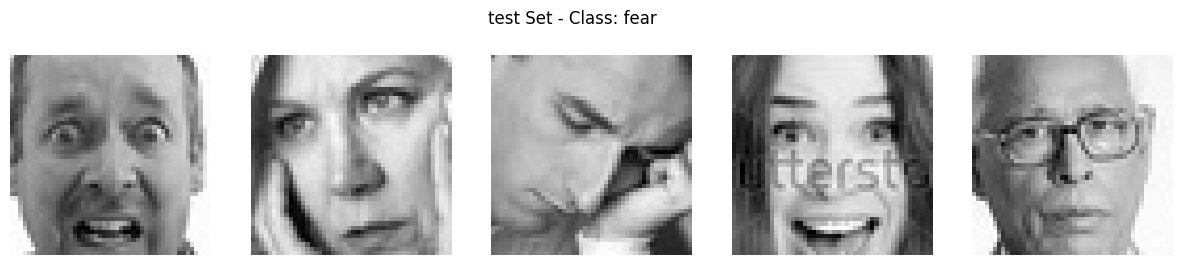


Class: happy


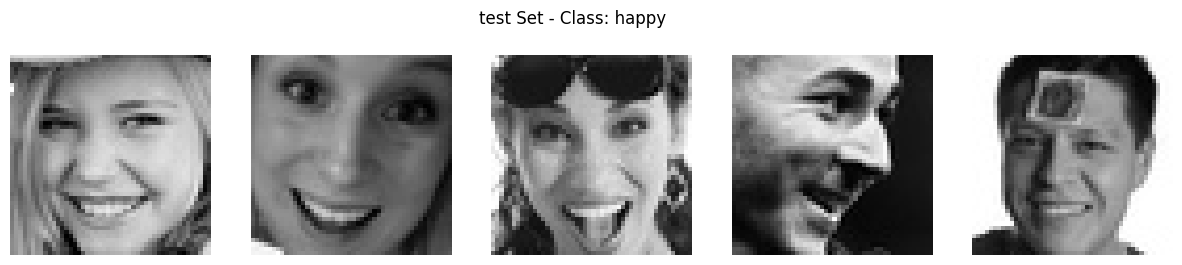


Class: neutral


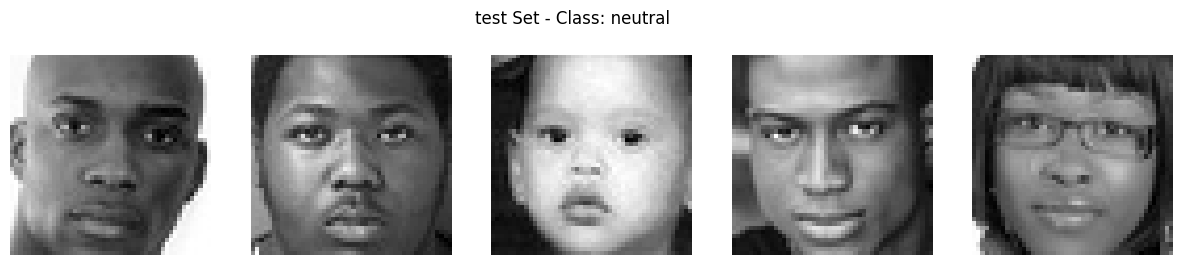


Class: sad


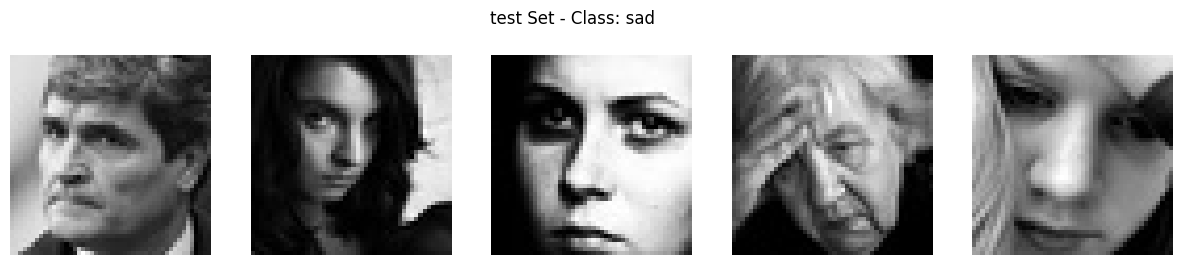


Class: surprise


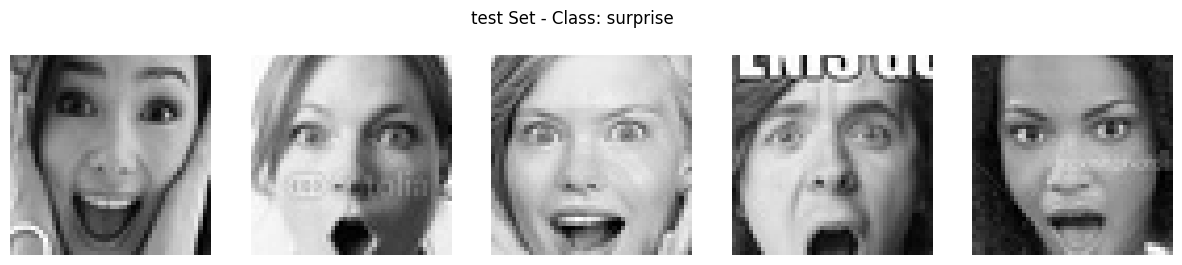

In [ ]:
import random
import os
import numpy as np
import matplotlib.image as mpimg

import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Function to count the number of images in each class and display random images
def display_image_counts_bar_and_pie(dataset_path, set_name):
    class_counts = {}
    total_count = 0
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']  # List of colors for each bar
    color_index = 0

    for class_name in os.listdir(os.path.join(dataset_path, set_name)):
        class_path = os.path.join(dataset_path, set_name, class_name)
        if os.path.isdir(class_path):
            # Count the number of images in each class
            count = len(os.listdir(class_path))
            total_count += count
            class_counts[class_name] = count

            # Display 5 random images from each class
            print(f"\nClass: {class_name}")
            image_files = os.listdir(class_path)
            random.shuffle(image_files)
            plt.figure(figsize=(15, 3))
            for i in range(5):
                image_file = random.choice(image_files)
                image_path = os.path.join(class_path, image_file)
                image = mpimg.imread(image_path)
                plt.subplot(1, 5, i + 1)
                plt.imshow(image, cmap='gray')  # Assume images are grayscale
                plt.axis('off')
            plt.suptitle(f"{set_name} Set - Class: {class_name}")
            plt.show()

    # Create bar chart
    fig_bar = go.Figure()
    for class_name, count in class_counts.items():
        fig_bar.add_trace(go.Bar(x=[class_name], y=[count], name=class_name, marker_color=colors[color_index]))
        color_index = (color_index + 1) % len(colors)  # Increment color index and wrap around if necessary
    fig_bar.update_layout(title_text=f"Image Counts in {set_name} Set")

    # Create pie chart
    fig_pie = go.Figure()
    fig_pie.add_trace(go.Pie(labels=list(class_counts.keys()), values=list(class_counts.values()), name=set_name))
    fig_pie.update_layout(title_text=f"Class Distribution in {set_name} Set")

    # Show the plots
    fig_bar.show()
    fig_pie.show()

# Call the function to display images, bar chart, and pie chart for both train and test sets
for set_name in ['train', 'test']:
    display_image_counts_bar_and_pie(dataset_path, set_name)


In [ ]:
test_dir='/content/drive/MyDrive/images/test'
train_dir='/content/drive/MyDrive/images/train'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.031125898894494,
 1: 9.443315858453474,
 2: 1.0034817729187702,
 3: 0.5747188322565207,
 4: 0.8264322991340254,
 5: 0.8337962159347335,
 6: 1.2846445286382884}

In [ ]:
input_shape = (224, 224, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

In [ ]:

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
train_history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=50,
    validation_data=test_generator,
    validation_steps=100,
    class_weight=class_weights_dict,callbacks=[checkpoint, reduce_lr, early_stopping]
)

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 1.9214 - accuracy: 0.2123
Epoch 1: val_loss improved from inf to 1.84848, saving model to best_model.h5
200/200 [==============================] - 201s 818ms/step - loss: 1.9214 - accuracy: 0.2123 - val_loss: 1.8485 - val_accuracy: 0.2366 - lr: 1.0000e-04
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 1.8325 - accuracy: 0.2412
Epoch 2: val_loss improved from 1.84848 to 1.76984, saving model to best_model.h5
200/200 [==============================] - 139s 695ms/step - loss: 1.8325 - accuracy: 0.2412 - val_loss: 1.7698 - val_accuracy: 0.3053 - lr: 1.0000e-04
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 1.7601 - accuracy: 0.3023
Epoch 3: val_loss improved from 1.76984 to 1.58143, saving model to best_model.h5
200/200 [==============================] - 145s 724ms/step - loss: 1.7601 - accuracy: 0.3023 - val_loss: 1.5814 - val_accuracy: 0.4087 - lr: 1.0000e-04
Epoch 4/50
200

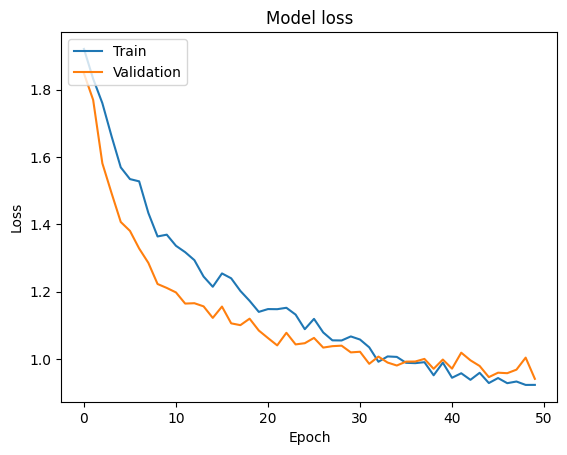

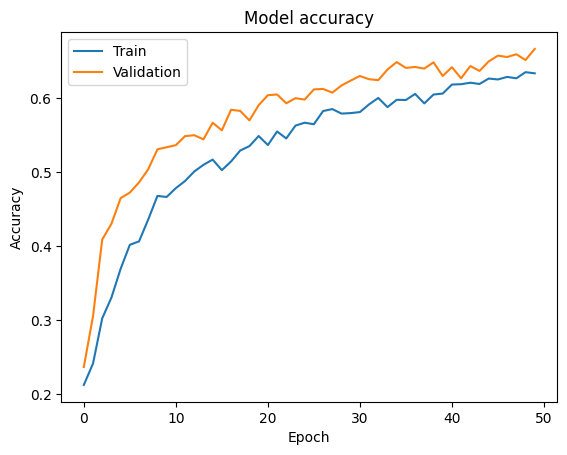

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
print("Training Loss:", train_history.history['loss'])
print("Validation Loss:", train_history.history['val_loss'])
print("Training Accuracy:", train_history.history['accuracy'])
print("Validation Accuracy:", train_history.history['val_accuracy'])


Training Loss: [1.9213955402374268, 1.8325223922729492, 1.760108232498169, 1.6619148254394531, 1.5692209005355835, 1.5344123840332031, 1.527656078338623, 1.433638095855713, 1.3638323545455933, 1.3691526651382446, 1.336073637008667, 1.3171099424362183, 1.2934646606445312, 1.244638442993164, 1.214285135269165, 1.2539507150650024, 1.2394131422042847, 1.2018647193908691, 1.1725035905838013, 1.139603853225708, 1.1479427814483643, 1.1476129293441772, 1.1517826318740845, 1.1315301656723022, 1.0881125926971436, 1.118851900100708, 1.0784900188446045, 1.0549724102020264, 1.054604411125183, 1.0666306018829346, 1.0573726892471313, 1.0342556238174438, 0.991334855556488, 1.007170557975769, 1.0057520866394043, 0.9882279634475708, 0.9871987700462341, 0.9900431632995605, 0.9511235952377319, 0.9886186718940735, 0.9437488317489624, 0.9571447968482971, 0.9376180171966553, 0.958498477935791, 0.9280238151550293, 0.9428804516792297, 0.9276332855224609, 0.9325926303863525, 0.9224594831466675, 0.92256271839141

In [ ]:
# redefining the test generator so it doesnt shuffle
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

Found 7066 images belonging to 7 classes.
221/221 [==============================] - 31s 140ms/step


In [ ]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57       960
           1       0.81      0.55      0.66       111
           2       0.58      0.30      0.40      1018
           3       0.86      0.87      0.86      1825
           4       0.52      0.78      0.62      1216
           5       0.56      0.47      0.51      1139
           6       0.75      0.78      0.77       797

    accuracy                           0.65      7066
   macro avg       0.66      0.62      0.63      7066
weighted avg       0.66      0.65      0.64      7066



Text(0.5, 1.0, 'Confusion Matrix')

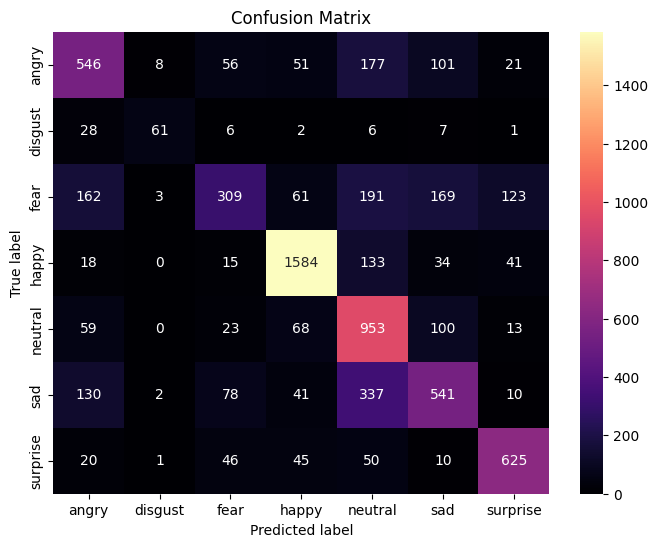

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=classes, yticklabels=classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

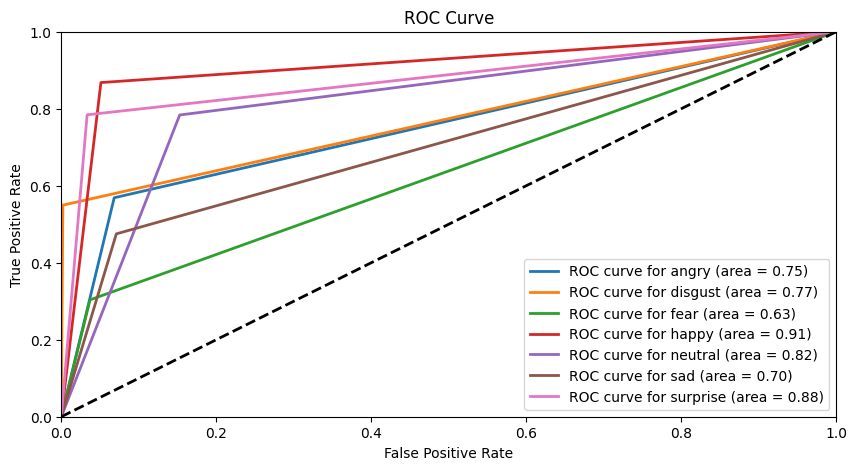

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [ ]:
model.save('EmotionDetector.h5')

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("emotiondetector.json",'w') as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")

## Conclusion <a class="anchor" id="con"></a>

The results are a little less that I hoped for, but that's okay. The main goal of this notebook was to test out transfer learning and it does indeed help a whole lot but picking the right network takes some trial and error. Overall, this project had been a fun experience.

If you have any questions or recommendations feel free to comment, and I hope you found this notebook helpful.